Training until validation scores don't improve for 300 rounds.
[200]	valid_0's binary_logloss: 0.335519	valid_0's logloss: 0.664481
[400]	valid_0's binary_logloss: 0.25511	valid_0's logloss: 0.74489
[600]	valid_0's binary_logloss: 0.220507	valid_0's logloss: 0.779493
[800]	valid_0's binary_logloss: 0.235655	valid_0's logloss: 0.764345
Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.215619	valid_0's logloss: 0.784381
Training until validation scores don't improve for 300 rounds.
[200]	valid_0's binary_logloss: 0.335519	valid_0's logloss: 0.664481
[400]	valid_0's binary_logloss: 0.260643	valid_0's logloss: 0.739357
[600]	valid_0's binary_logloss: 0.212884	valid_0's logloss: 0.787116
[800]	valid_0's binary_logloss: 0.216188	valid_0's logloss: 0.783812
Early stopping, best iteration is:
[645]	valid_0's binary_logloss: 0.206063	valid_0's logloss: 0.793937
Plot feature importances...


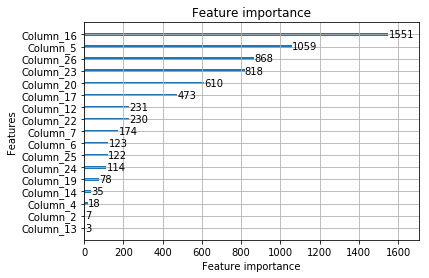

In [6]:
#################################################
#created the 04/05/2018 09:52 by Alexis Blanchet#
#################################################
#-*- coding: utf-8 -*-
'''

'''

'''
Améliorations possibles:

'''
import warnings
warnings.filterwarnings('ignore')
#################################################
###########        Imports      #################
#################################################
import sys
import numpy as np
import pandas as pd
import scipy.stats
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss
from sklearn.externals import joblib
#################################################
########### Global variables ####################
#################################################
### LGB modeling
params = {'learning_rate': 0.015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 1,
          'reg_lambda': 1,
          'max_depth' : 10,
          'min_data_in_leaf': 1, 
          'boosting': 'dart',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}

params1 = {'learning_rate': 0.015,
          'subsample': 0.9,
          #'subsample_freq': 1,
          'colsample_bytree': 0.9,
          'colsample_bylevel':0.9,
          'reg_alpha': 1,
          'reg_lambda': 1,
          'max_depth' : 8,
          'num_leaves': 15,        
          'min_data_in_leaf': 1, 
          'boosting': 'dart',#'rf','dart','goss','gbdt'
          'objective': 'binary',
          'metric': 'binary_logloss',
          'is_training_metric': True,
          'seed': 99,}
MAX_TREES = 5000

######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, x1, y1,x2,y2):
        watchlist = [(lgb.Dataset(x1, label=y1), 'train'), (lgb.Dataset(x2, label=y2), 'valid')]
        self.clf2 = lgb.train(params, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=200, feval=logloss_lgbm, early_stopping_rounds=300)
        self.clf1 = lgb.train(params1, lgb.Dataset(x1, label=y1), MAX_TREES, lgb.Dataset(x2, label=y2),verbose_eval=200, feval=logloss_lgbm, early_stopping_rounds=300)
    def predict(self, X):
        return self.clf1.predict(X)

    def predict_proba(self, X):
        res1 = self.clf1.predict(X, num_iteration = self.clf1.best_iteration)
        res2 = self.clf2.predict(X,num_iteration = self.clf2.best_iteration)
        return np.array([[1-0.5*(a+b),0.5*(a+b)] for a,b in zip(res1,res2)])
    
fileX_train ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180430_0_192_0_cleandata-processed.csv'
fileY_train = '/home/alexis/Bureau/historique/label-30-04.csv'

fileX_valid ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180507_0_192_0_cleandata-processed.csv'
fileY_valid = '/home/alexis/Bureau/historique/label-07-05.csv'

fileX_test ='/home/alexis/Bureau/Stage/Time-series/data/processed/sfrdaily_20180509_0_192_0_cleandata-processed.csv'
fileY_test = '/home/alexis/Bureau/historique/label-09-05.csv'


#################################################
########### Important functions #################
#################################################
def load(fileX,fileY):
    df = pd.read_csv(fileX)
    y = pd.read_csv(fileY)
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(1)
    X_train = df.values
    t = df['t']
    y_train = y['label'][3:].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    return  X_train,y_train,t



def model_fit(X1,y1,X2,y2):
    clf = Classifier()
    clf.fit(X1,[Y[0] for Y in y1],X2,[Y[0] for Y in y2])
    return clf

def find_index(l,v):
    res = []
    for i, j in enumerate(l):
        if(j == v):
            res.append(i)
    return res    

def mesure(y_pred,y_true):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(y_pred)-1):
        i = i+1
        if(y_pred[i] == 1):
            if(sum(y_true[i-1:i+1])>0):
                TP += 1
            else:
                FP += 1
    for i in range(len(y_true)-1):
        i = i+1
        if(y_true[i] == 1):
            if(sum(y_pred[i-1:i+1])>0):
                pass
            else:
                FN += 1
    return TP,FP,FN

def plot_res(df,pred,y):
    x = df
    t= [i/60 +3 for i in range(len(x))]
    tp = np.sum([z*x for z,x in zip(pred,y)])
    fp = np.sum([np.clip(z-x,0,1) for z,x in zip(pred,y)])
    fn = np.sum([np.clip(z-x,0,1) for z,x in zip(y,pred)])
    
    beta = 2
    p = tp/np.sum(pred)
    r = tp/np.sum(y)
    beta_squared = beta ** 2
    f = (beta_squared + 1) * (p * r) / (beta_squared * p + r)
    print('--------------------------------------------------')
    print("|| precison: "+str(p)+"|| recall: "+str(r)+"|| fbeta: "+str(f))
    
    
    tp,fp,fn = mesure(pred,y)
    beta = 2
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    beta_squared = beta ** 2
    f = (beta_squared + 1) * (p * r) / (beta_squared * p + r)
    
    
    print("|| precison: "+str(p)+"|| recall: "+str(r)+"|| fbeta: "+str(f))
    print('--------------------------------------------------')
    l1 = find_index(pred,1)

    x1 = [t[i] for i in l1]
    y1 = [x[i] for i in l1]
    l3 = find_index(y,1)
    x3 = [t[i] for i in l3]
    y3 = [x[i] for i in l3]

    trace1 = go.Scatter(
            x= t,
            y= x,
            name = 'true',

    )
    trace2 = go.Scatter(
            x =x1,
            y=y1,
            mode = 'markers',
            name ='train',
    )
    trace3 = go.Scatter(
            x=0,
            y= 0,
            mode = 'markers',
            name = 'test',
    )
    trace4 = go.Scatter(
            x=x3,
            y=y3,
            mode = 'markers',
            name = 'true markers'
    )

    fig = tools.make_subplots(rows=4, cols=1, specs=[[{}], [{}], [{}], [{}]],
                                  shared_xaxes=True, shared_yaxes=True,
                                  vertical_spacing=0.001)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 1)
    fig.append_trace(trace4, 1, 1)

    fig['layout'].update(height=3000, width=2000, title='Annomalie detection')
    #plot(fig, filename='LGBM.html')
    return 0
def save_model(model):
    joblib.dump(model.clf1, 'model/LGBM1.pkl')
    joblib.dump(model.clf2, 'model/LGBM2.pkl')
    model.clf1.booster_.save_model('model/LGBM1.txt')
    model.clf2.booster_.save_model('model/LGBM2.txt')

def logloss_lgbm(preds, dtrain):
    labels = dtrain.get_label()
    score = 1-log_loss(labels, preds)
    return 'logloss', score,True

#################################################
########### main with options ###################
#################################################

THRESHOLD = 0.5
X_train,Y_train,_ = load(fileX_train,fileY_train)
X_valid,Y_valid,_ = load(fileX_valid,fileY_valid)
X_test,Y_test,t = load(fileX_test,fileY_test)
        
model = model_fit(X_train,Y_train,X_valid,Y_valid)
pred = model.predict_proba(X_test)

print('Plot feature importances...')
ax = lgb.plot_importance(model.clf1, max_num_features=30)
#plt.show()
    






In [10]:
# plot results
for h in [0.15,0.16,0.17,0.18,0.19,0.20]:
    print(h)
    testPredict = list([1 if i[1]>h else 0 for i in pred])
    plot_res(t,testPredict,Y_test)
    
pred_valid = model.predict_proba(X_valid)
res_valid = pd.DataFrame(pred_valid)
res_valid.to_csv('lightGBM_valid.csv',index=False)
    
res = pd.DataFrame(pred)
res.to_csv('lightGBM.csv',index=False)
save_model(model)

0.15
--------------------------------------------------
|| precison: 0.19512195122|| recall: 0.842105263158|| fbeta: 0.506329113924
|| precison: 0.2967479674796748|| recall: 0.9125|| fbeta: 0.6448763250883391
--------------------------------------------------
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.16
--------------------------------------------------
|| precison: 0.228155339806|| recall: 0.824561403509|| fbeta: 0.541474654378
|| precison: 0.32038834951456313|| recall: 0.8918918918918919|| fbeta: 0.6573705179282868
--------------------------------------------------
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]

0.17
--------------------------------------------------
|| precison: 0.228426395939|| recall: 0.789473684211|| fbeta: 0.529411764706
|| precison: 0.29949238578680204|| recall: 0.8676470588235294|| fbeta: 0.6289978678038378
-------------------------------------

AttributeError: 'Booster' object has no attribute 'booster_'